In [ ]:
# Correlation studies between Aggregated variables
This plots will shown the correlation (or lack of) between QUEUE time, NETWORK rate and the aggregated_fts values, LINK rate, Number of files in queue per activity
* import libraries
* create the RSE to site mapping
* get the data
* plot plot plot

In [1]:
#matplotlib stuff
%matplotlib inline
import matplotlib
matplotlib.rc('font', **{'size': 12})

# other imports
import datetime
from elasticsearch import Elasticsearch, helpers
from elasticsearch.helpers import scan
import datetime as dt
import json
import numpy as np
import pandas as pd
import pickle
import requests
import time
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2

from scipy.optimize import leastsq

from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
# Get AGIS endpoints (RSEs) and site names
r = requests.get('http://atlas-agis-api.cern.ch/request/site/query/list/ddmendpoints?json')
j = r.json()
#Create RSE to site name dictionary
rse2site = {}
for i in j:
    for ep in i['ddmendpoints']:
        rse2site[ep]=i['name']

In [3]:
es = Elasticsearch([{'host':'atlas-kibana.mwt2.org', 'port':9200}],timeout=60)
DATE = '2017-02-01'  # yyyy-mm-dd
DELTA = 7
# Generate the indexes to scan
dt.datetime.strptime(DATE,'%Y-%m-%d')
index_list = []
for i in range(-1, DELTA+1):
    index_list.append('fts_'+(dt.datetime.strptime(DATE,'%Y-%m-%d')
                      + dt.timedelta(days=i)).strftime('%Y-%m-%d'))
indexes = ','.join(index_list)
print (index_list)
period_start = dt.datetime.strptime(DATE,'%Y-%m-%d')
period_end = dt.datetime.strptime(DATE,'%Y-%m-%d') + dt.timedelta(days=7)
transfer_query = {
    "size": 0,
    "_source": ["src_rse", "dst_rse", "activity","bytes","submitted_at","started_at","transferred_at"],
    'query':{
        "bool" : {
            "must" : [
                {"range" : {"transferred_at" : {  "gte": period_start } }},
                {"range" : {"submitted_at" :   {  "lt" : period_end } }}
                ]
        }
    }
                
}
scroll = scan(client=es, index=indexes, query=transfer_query, scroll='5m', timeout="5m", size=10000)
epoch = dt.datetime(1970,1,1)
st = time.time()
count = 0
data = []
for res in scroll:
    r = res['_source']
    if not count%1000000 : print (count)
    r['submitted_at'] = (dt.datetime.strptime(r['submitted_at'].strip('Z').split('.')[0], '%Y-%m-%dT%H:%M:%S') - epoch).total_seconds()
    r['started_at'] = (dt.datetime.strptime(r['started_at'].strip('Z').split('.')[0], '%Y-%m-%dT%H:%M:%S') - epoch).total_seconds()
    r['transferred_at'] = (dt.datetime.strptime(r['transferred_at'].strip('Z').split('.')[0], '%Y-%m-%dT%H:%M:%S') - epoch).total_seconds()
    data.append([rse2site[r['src_rse']]+'__'+rse2site[r['dst_rse']]+'__'+r['activity'],r['bytes'],r['submitted_at'],r['started_at'],r['transferred_at']])
    count += 1
print('Reading took',time.time() - st,'seconds.')
data = pd.DataFrame(data, columns=['LINK', 'SIZE', 'SUBMITTED', 'STARTED', 'ENDED'])
data['Q_TIME'] = data['STARTED'] - data['SUBMITTED']
data['N_RATE'] = data.SIZE/(data['ENDED'] - data['STARTED'])
data['T_TIME'] = data['ENDED'] - data['SUBMITTED']
data['N_RATE_MB'] = data['N_RATE']/(1024*1024)
data['SIZE_MB'] = data['SIZE']/(1024*1024)

['fts_2017-01-31', 'fts_2017-02-01', 'fts_2017-02-02', 'fts_2017-02-03', 'fts_2017-02-04', 'fts_2017-02-05', 'fts_2017-02-06', 'fts_2017-02-07', 'fts_2017-02-08']
0
1000000
2000000
3000000
4000000
5000000
6000000
7000000
8000000
9000000
10000000
11000000
12000000
13000000
14000000
15000000
16000000
17000000
18000000
19000000
20000000
21000000
Reading took 2483.628025531769 seconds.


In [4]:
####################
# LINK RATES
######
index_list = []
for i in range(0, DELTA+1):
    index_list.append('fts-aggregates_'+(dt.datetime.strptime(DATE,'%Y-%m-%d')
                      + dt.timedelta(days=i)).strftime('%Y-%-m'))
indexes = ','.join(index_list)
print (index_list)

period_start = dt.datetime.strptime(DATE,'%Y-%m-%d')
period_end = dt.datetime.strptime(DATE,'%Y-%m-%d') + dt.timedelta(days=10)
transfer_query = {
    "size": 0,
    "_source": ["src", "dest", "timestamp","rate"],
    'query':{
        "bool" : {
            "must" : [
                {"term" : { "src" : "CERN-PROD" }},
                {"term" : { "dest" : "BNL-ATLAS" }},
                {"range" : {"timestamp" : {  "gte": period_start } }},
                {"range" : {"timestamp" : {  "lt" : period_end } }}
                ]
        }
    }
                
}
scroll = scan(client=es, index=indexes, query=transfer_query, scroll='5m', timeout="5m", size=10000)
epoch = dt.datetime(1970,1,1)
st = time.time()
count = 0
l_rates = []
tsindex = []
for res in scroll:
    r = res['_source']
    #if not count%1000000 : print (count)
    #print (r.keys())
    #r['timestamp'] = (dt.datetime.strptime(r['timestamp'].strip('Z').split('.')[0], '%Y-%m-%dT%H:%M:%S') - epoch).total_seconds()
    try:
        l_rates.append([r['src']+'__'+r['dest'],r['timestamp']/1000,r['rate']])
        tsindex.append(r['timestamp']/1000)
    except KeyError:
        continue
    count += 1
print('Reading took',time.time() - st,'seconds.')
print(count)
l_rates = pd.DataFrame(l_rates, columns=['LINK', 'TS', 'RATE'], index=tsindex)

##############
# CERN RATES
#
period_start = dt.datetime.strptime(DATE,'%Y-%m-%d')
period_end = dt.datetime.strptime(DATE,'%Y-%m-%d') + dt.timedelta(days=10)
transfer_query = {
    "size": 0,
    "_source": ["name", "timestamp", "ingress", "egress", "incoming", "outcoming"],
    'query':{
        "bool" : {
            "must" : [
                {"term" : { "name" : "CERN-PROD" }},
                {"range" : {"timestamp" : {  "gte": period_start } }},
                {"range" : {"timestamp" : {  "lt" : period_end } }}
                ]
        }
    }
                
}
scroll = scan(client=es, index=indexes, query=transfer_query, scroll='5m', timeout="5m", size=10000)
epoch = dt.datetime(1970,1,1)
st = time.time()
count = 0
cern_rates = []
tsindex = []
for res in scroll:
    r = res['_source']
    #not count%1000000 : print (count)
    #print (r.keys())
    #r['timestamp'] = (dt.datetime.strptime(r['timestamp'].strip('Z').split('.')[0], '%Y-%m-%dT%H:%M:%S') - epoch).total_seconds()
    try:
        cern_rates.append([r['name'],r['timestamp']/1000,r['ingress'], r['egress'], r['incoming'],r['outcoming']])
        tsindex.append(r['timestamp']/1000)
    except KeyError:
        break
    count += 1
print('Reading took',time.time() - st,'seconds.')
print(count)
cern_rates = pd.DataFrame(cern_rates, columns=['NAME', 'TS', 'ING','EGR', 'INC', 'OUTC'], index=tsindex)
#####################
# BNL RATES
#####
period_start = dt.datetime.strptime(DATE,'%Y-%m-%d')
period_end = dt.datetime.strptime(DATE,'%Y-%m-%d') + dt.timedelta(days=10)
transfer_query = {
    "size": 0,
    "_source": ["name", "timestamp","ingress", "egress", "incoming", "outcoming"],
    'query':{
        "bool" : {
            "must" : [
                {"term" : { "name" : "BNL-ATLAS" }},
                {"range" : {"timestamp" : {  "gte": period_start } }},
                {"range" : {"timestamp" : {  "lt" : period_end } }}
                ]
        }
    }
                
}
scroll = scan(client=es, index=indexes, query=transfer_query, scroll='5m', timeout="5m", size=10000)
epoch = dt.datetime(1970,1,1)
st = time.time()
count = 0
bnl_rates = []
tsindex2 = []
for res in scroll:
    r = res['_source']
    #if not count%1000000 : print (count)
    #print (r.keys())
    #r['timestamp'] = (dt.datetime.strptime(r['timestamp'].strip('Z').split('.')[0], '%Y-%m-%dT%H:%M:%S') - epoch).total_seconds()
    try:
        bnl_rates.append([r['name'],r['timestamp']/1000,r['ingress'], r['egress'], r['incoming'],r['outcoming']])
        tsindex2.append(r['timestamp']/1000)
    except KeyError:
        continue
    count += 1
print('Reading took',time.time() - st,'seconds.')
print(count)
bnl_rates = pd.DataFrame(bnl_rates, columns=['NAME', 'TS', 'ING','EGR', 'INC', 'OUTC'], index=tsindex2)


['fts-aggregates_2017-2', 'fts-aggregates_2017-2', 'fts-aggregates_2017-2', 'fts-aggregates_2017-2', 'fts-aggregates_2017-2', 'fts-aggregates_2017-2', 'fts-aggregates_2017-2', 'fts-aggregates_2017-2']
Reading took 0.39307355880737305 seconds.
14400
Reading took 0.9522004127502441 seconds.
14400
Reading took 0.3273036479949951 seconds.
14400


In [52]:
src = 'CERN-PROD'
dst = 'BNL-ATLAS'
activities = [ "Data Consolidation",
               #"Data Brokering",
               #"Data Rebalancing",
               "Express",
               #"Functional Test",
               "Production Input",
               "Production Output",
               #"Recovery",
               "Staging",
               "T0 Export",
               #"T0 Tape",
               "User Subscriptions",
             ]
ts = time.time()
cut = data.where(data.LINK == src+'__'+dst+'__'+activities[0]).dropna()
for act in activities[1:]:
    subcut = data.where(data.LINK == src+'__'+dst+'__'+act).dropna()
    print(len(subcut))
    cut = pd.concat([cut,subcut])
link_rate = []
c_ing = []
c_egr = []
c_inc = []
c_out =[]
b_ing = []
b_egr = []
b_inc = []
b_out =[]
for t in cut.itertuples():
    t_index = (t.STARTED - (t.STARTED%60))-60  # link rate at the previous minute
    #print (rates.iloc(t_index))
    link_rate.append(l_rates.loc[t_index].RATE)
    c_ing.append(cern_rates.loc[t_index].ING)
    c_egr.append(cern_rates.loc[t_index].EGR)
    c_inc.append(cern_rates.loc[t_index].INC)
    c_out.append(cern_rates.loc[t_index].OUTC)
    b_ing.append(bnl_rates.loc[t_index].ING)
    b_egr.append(bnl_rates.loc[t_index].EGR)
    b_inc.append(bnl_rates.loc[t_index].INC)
    b_out.append(bnl_rates.loc[t_index].OUTC)

cut['LINK_RATE'] = link_rate
cut['CERN_ING'] = c_ing
cut['CERN_EGR'] = c_egr
cut['CERN_INC'] = c_inc
cut['CERN_OUT'] = c_out
cut['BNL_ING'] = b_ing
cut['BNL_EGR'] = b_egr
cut['BNL_INC'] = b_inc
cut['BNL_OUT'] = b_out
cut = cut.set_index(pd.to_datetime(cut.STARTED, unit='s'))
print('Done in %d sec.'%(time.time()-ts))

12332
14004
30830
8213
239
30554
Done in 472 sec.


### Correlation between the variables
In all the cases, all the activities are taking into account unless it specified.

This is something I was expecting


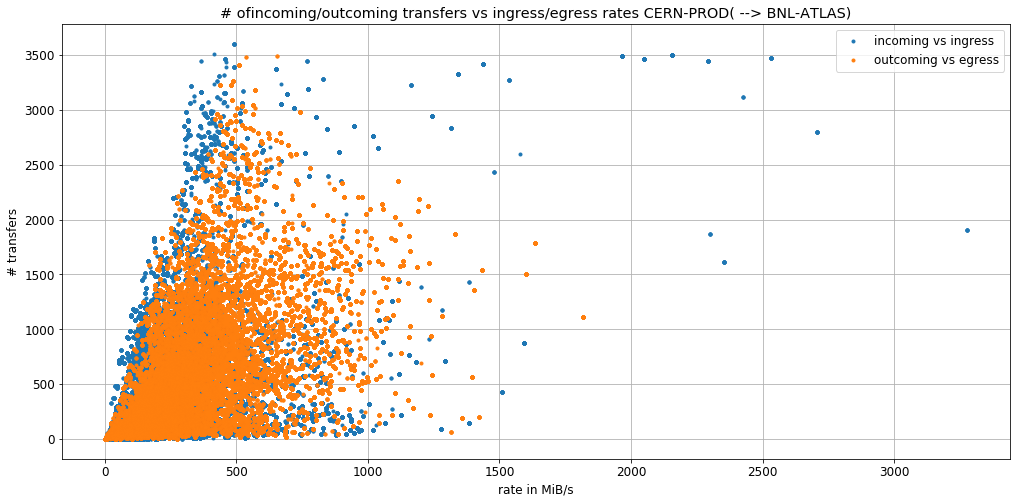

In [198]:
plt.plot(cut.CERN_INC, cut.CERN_ING,'.', label='incoming vs ingress')
plt.plot(cut.CERN_OUT, cut.CERN_EGR,'.', label='outcoming vs egress')
plt.title('# ofincoming/outcoming transfers vs ingress/egress rates CERN-PROD( --> BNL-ATLAS)')
#plt.yscale('log')
#plt.xscale('log')
plt.xlabel('rate in MiB/s')
plt.ylabel('# transfers')

fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
print('This is something I was expecting')
plt.show()

This is something I was expecting


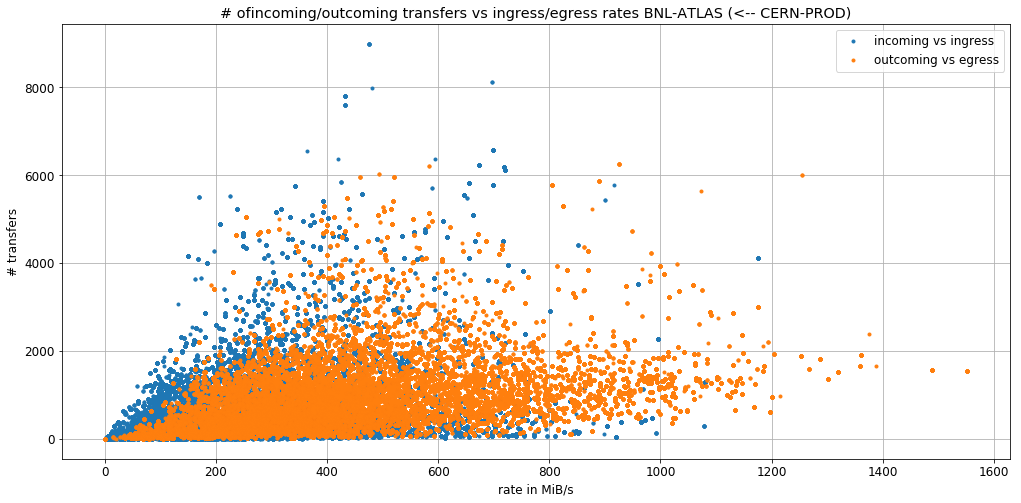

In [199]:
plt.plot(cut.BNL_INC, cut.BNL_ING,'.', label='incoming vs ingress')
plt.plot(cut.BNL_OUT, cut.BNL_EGR,'.', label='outcoming vs egress')
plt.title('# ofincoming/outcoming transfers vs ingress/egress rates BNL-ATLAS (<-- CERN-PROD)')
#plt.yscale('log')
#plt.xscale('log')
plt.xlabel('rate in MiB/s')
plt.ylabel('# transfers')

fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
print('This is something I was expecting')
plt.show()

Correlation values for CERN --> BNL (Prod Input only)

In [36]:
print(len(cut_pi))
cut_pi.corr().N_RATE

NameError: name 'cut_pi' is not defined

Correlation values for CERN --> BNL (all important activities)

In [8]:
cut['OCC_C'] = cut.CERN_INC + cut.CERN_OUT + cut.BNL_INC + cut.BNL_OUT
cut.corr().Q_TIME.sort_values()

SUBMITTED   -0.210073
STARTED     -0.190803
ENDED       -0.190679
CERN_OUT    -0.079030
BNL_EGR     -0.068874
OCC_C       -0.068769
BNL_OUT     -0.065852
CERN_INC    -0.014958
BNL_INC      0.005736
CERN_ING     0.086248
CERN_EGR     0.141585
BNL_ING      0.144817
LINK_RATE    0.334879
N_RATE_MB    0.392281
N_RATE       0.392281
SIZE_MB      0.501945
SIZE         0.501945
T_TIME       0.999844
Q_TIME       1.000000
Name: Q_TIME, dtype: float64

## Transfer rates vs Other variables

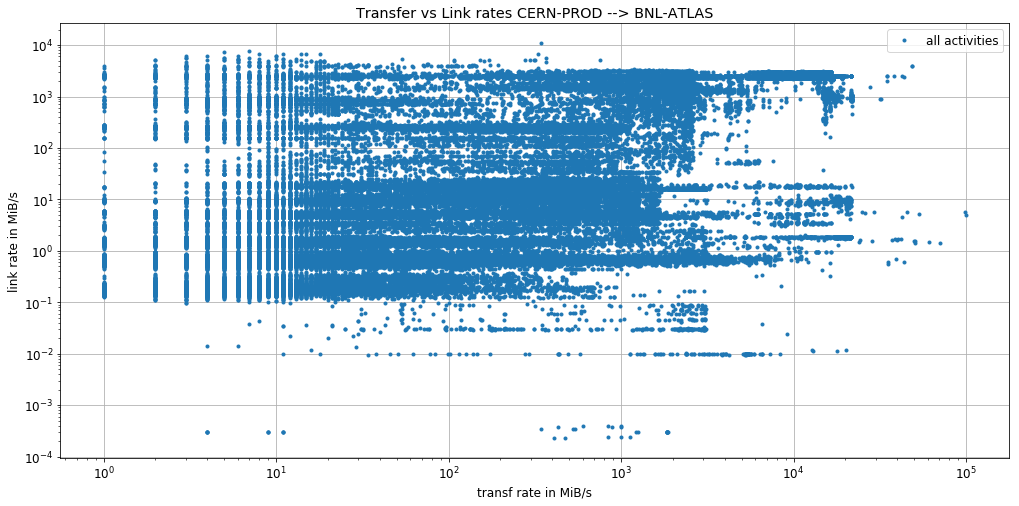

In [7]:
plt.plot(cut.Q_TIME, cut.SIZE_MB,'.', label='all activities')
#plt.plot(cut_pi.N_RATE_MB, cut_pi.LINK_RATE,'.', label='only prod input')
plt.title('Transfer vs Link rates CERN-PROD --> BNL-ATLAS')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('transf rate in MiB/s')
plt.ylabel('link rate in MiB/s')

fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()

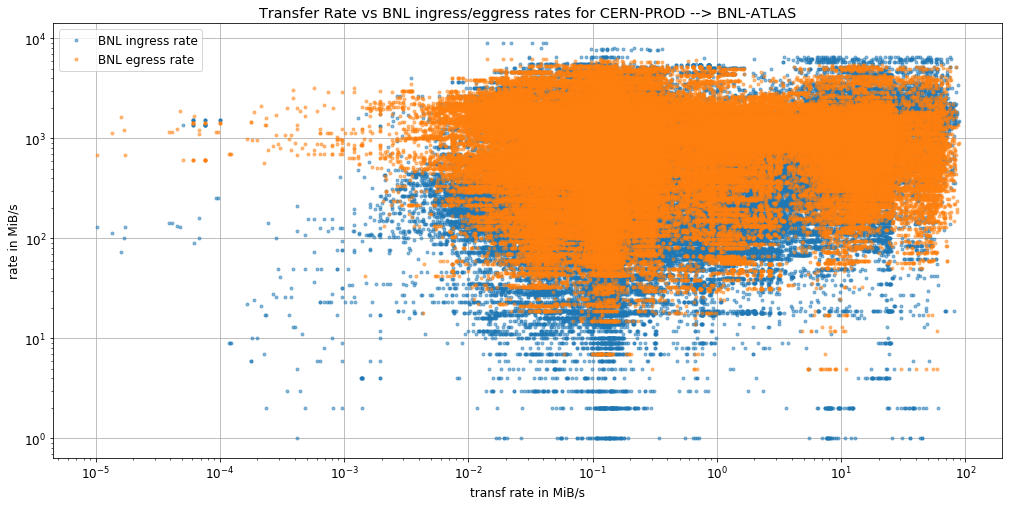

In [212]:
#plt.plot(cut.N_RATE, cut.CERN_ING,'.', alpha=0.5, label='CERN ingress rate')
#plt.plot(cut.N_RATE, cut.CERN_EGR,'.', alpha=0.5, label='CERN ingress rate')
plt.plot(cut.N_RATE_MB, cut.BNL_ING,'.', alpha=0.5, label='BNL ingress rate')
plt.plot(cut.N_RATE_MB, cut.BNL_EGR,'.', alpha=0.5, label='BNL egress rate')
plt.title('Transfer Rate vs BNL ingress/eggress rates for CERN-PROD --> BNL-ATLAS')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('transf rate in MiB/s')
plt.ylabel('rate in MiB/s')

fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()

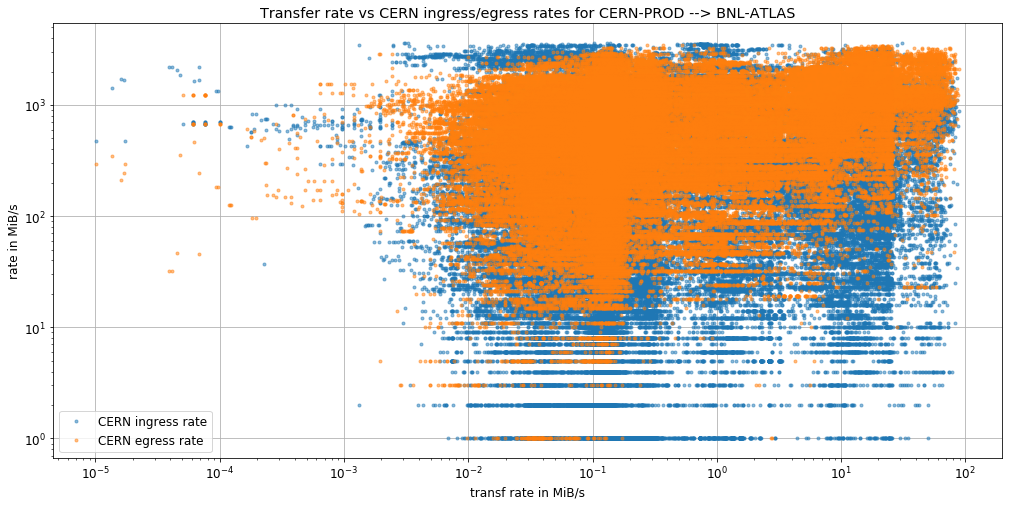

In [210]:
plt.plot(cut.N_RATE_MB, cut.CERN_ING,'.', alpha=0.5, label='CERN ingress rate')
plt.plot(cut.N_RATE_MB, cut.CERN_EGR,'.', alpha=0.5, label='CERN egress rate')
#plt.plot(cut.N_RATE_MB, cut.BNL_ING,'.', alpha=0.5, label='BNL ingress rate')
#plt.plot(cut.N_RATE_MB, cut.BNL_EGR,'.', alpha=0.5, label='BNL egress rate')
plt.title('Transfer rate vs CERN ingress/egress rates for CERN-PROD --> BNL-ATLAS')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('transf rate in MiB/s')
plt.ylabel('rate in MiB/s')

fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()

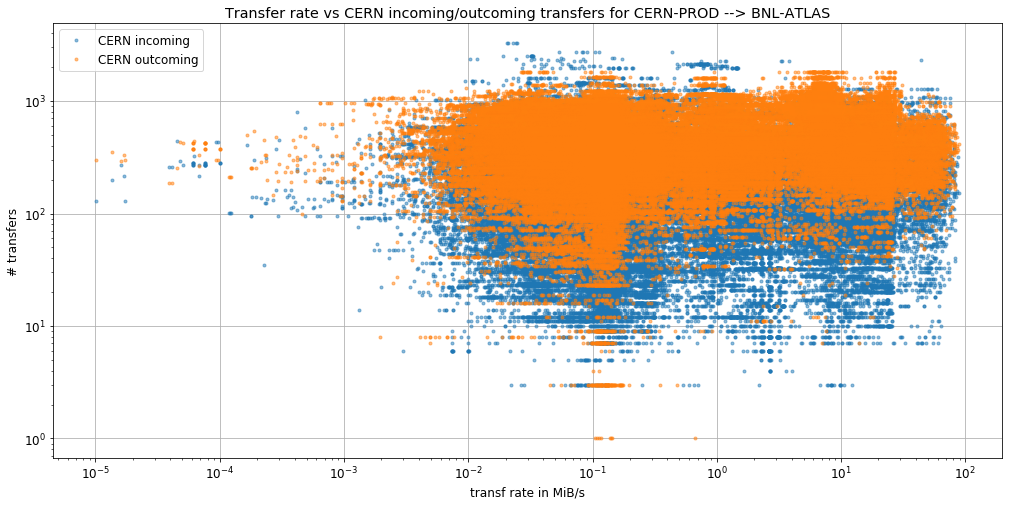

In [224]:
plt.plot(cut.N_RATE_MB, cut.CERN_INC,'.', alpha=0.5, label='CERN incoming')
plt.plot(cut.N_RATE_MB, cut.CERN_OUT,'.', alpha=0.5, label='CERN outcoming')
#plt.plot(cut.N_RATE_MB, cut.BNL_ING,'.', alpha=0.5, label='BNL ingress rate')
#plt.plot(cut.N_RATE_MB, cut.BNL_EGR,'.', alpha=0.5, label='BNL egress rate')
plt.title('Transfer rate vs CERN incoming/outcoming transfers for CERN-PROD --> BNL-ATLAS')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('transf rate in MiB/s')
plt.ylabel('# transfers')

fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()

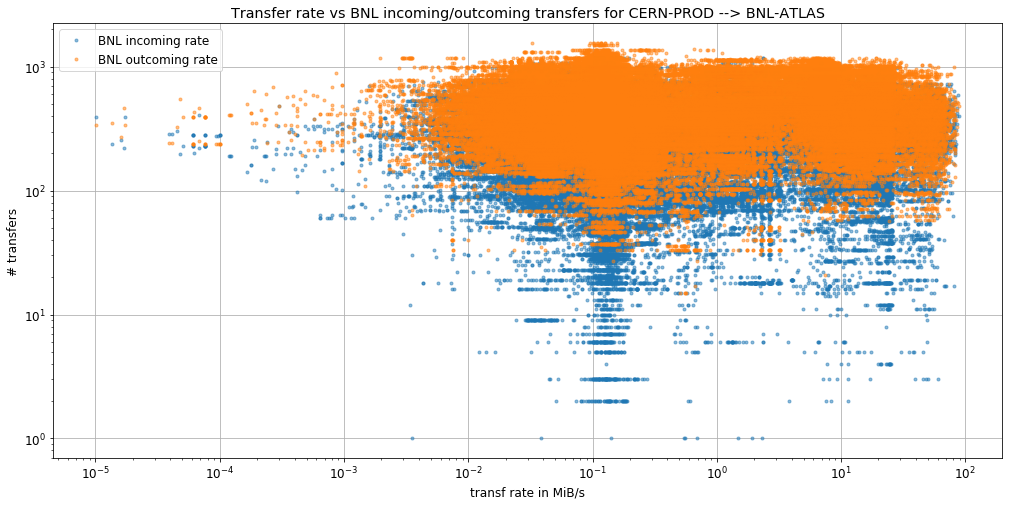

In [242]:
#plt.plot(cut.N_RATE_MB, cut.CERN_ING,'.', alpha=0.5, label='CERN ingress rate')
#plt.plot(cut.N_RATE_MB, cut.CERN_EGR,'.', alpha=0.5, label='CERN egress rate')
plt.plot(cut.N_RATE_MB, cut.BNL_INC,'.', alpha=0.5, label='BNL incoming rate')
plt.plot(cut.N_RATE_MB, cut.BNL_OUT,'.', alpha=0.5, label='BNL outcoming rate')
plt.title('Transfer rate vs BNL incoming/outcoming transfers for CERN-PROD --> BNL-ATLAS')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('transf rate in MiB/s')
plt.ylabel('# transfers')

fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()

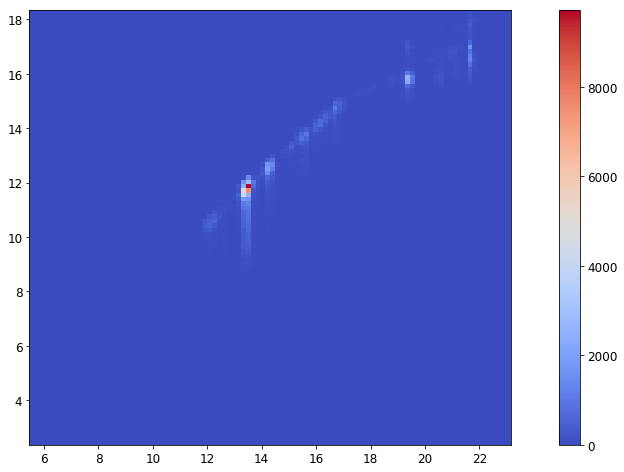

In [51]:
cut=cut[cut.BNL_INC>0]
cut=cut[cut.N_RATE_MB>0]

heatmap, xedges, yedges = np.histogram2d(np.log(cut.SIZE), np.log(cut.N_RATE), bins=100)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower', cmap='coolwarm')
plt.gcf().set_size_inches(17, 8)
plt.colorbar()
plt.show()

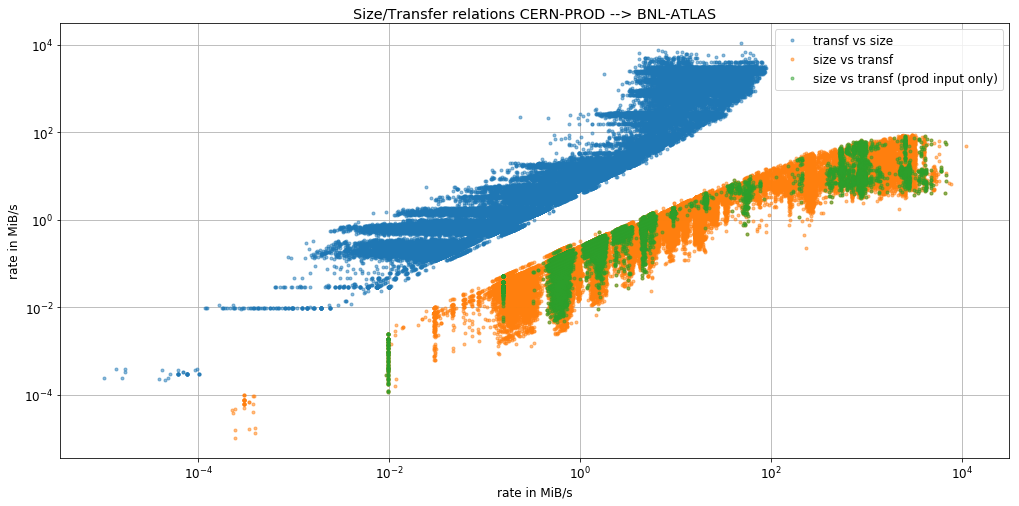

144262
14004


In [241]:
plt.plot(cut.N_RATE_MB, cut.SIZE_MB,'.', alpha=0.5, label='transf vs size')
plt.plot(cut.SIZE_MB, cut.N_RATE_MB,'.', alpha=0.5, label='size vs transf')
plt.plot(cut_pi.SIZE_MB, cut_pi.N_RATE_MB,'.', alpha=0.5, label='size vs transf (prod input only)')
#plt.plot(cut.N_RATE, cut.CERN_EGR,'.', alpha=0.5, label='CERN egress rate')
#plt.plot(cut.N_RATE, cut.BNL_ING,'.', alpha=0.5, label='BNL ingress rate')
#plt.plot(cut.N_RATE, cut.BNL_EGR,'.', alpha=0.5, label='BNL egress rate')
plt.title('Size/Transfer relations CERN-PROD --> BNL-ATLAS')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('rate in MiB/s')
plt.ylabel('rate in MiB/s')

fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()
print(len(cut))
print(len(cut_pi))

### New Not Linear Fit based in new data

In [107]:
def objective(vars, x, data):
    rate = vars[0]
    overhead = vars[1]
    diskrw_limit = vars[2]
    model = x/((x/rate)+overhead)
    model[model>float(diskrw_limit)] = diskrw_limit
    return data - model
def f( x, rate, overhead, diskrw_limit):
    model = x/((x/rate)+overhead)
    model[model>float(diskrw_limit)] = diskrw_limit
    return model

def ff(x, p):
    return f(x, *p)

def fit_leastsq(p0, datax, datay, function):

    errfunc = lambda p, x, y: function(x,p) - y

    pfit, pcov, infodict, errmsg, success = leastsq(errfunc, p0, args=(datax, datay), full_output=1)
    print(pfit)
    if (len(datay) > len(p0)) and pcov is not None:
        s_sq = (errfunc(pfit, datax, datay)**2).sum()/(len(datay)-len(p0))
        pcov = pcov * s_sq
    else:
        pcov = np.inf

    error = [] 
    print(pcov)
    for i in range(len(pfit)):
        try:
          error.append(np.absolute(pcov[i][i])**0.5)
        except:
          error.append( 0.00 )
    pfit_leastsq = pfit
    perr_leastsq = np.array(error) 
    return pfit_leastsq, perr_leastsq, infodict 

cut2 = cut.where(cut.N_RATE != np.inf).dropna()
print(len(cut.where(cut.N_RATE != np.inf).dropna()))
print(len(cut))
vars = [cut2.N_RATE.mean(), .1, 100.0]
#out = leastsq(objective, vars, args=(cut2.SIZE, cut2.N_RATE),full_output=1)
pfit, perr, infodict = fit_leastsq(vars, cut2.SIZE, cut2.N_RATE, ff)
 
print(pfit, perr, infodict)
rate = pfit[0]
overhead = pfit[1]
diskrw = pfit[2]
cut['NLFIT'] = cut.SIZE/((cut.SIZE/rate)+overhead)
cut['NLFIT'][cut['NLFIT']>diskrw]=diskrw

144312
144312
[  2.87198936e+07   1.87064968e+01   2.76194969e+07]
inf
[  2.87198936e+07   1.87064968e+01   2.76194969e+07] [ 0.  0.  0.] {'qtf': array([-16672.38731244, -26707.07198535, -64747.20506669]), 'ipvt': array([2, 1, 3], dtype=int32), 'fjac': array([[  5.42108637e+07,   3.10374983e-05,   3.80511486e-05, ...,
          1.87185928e-04,   1.00787951e-04,   1.02399481e-04],
       [ -5.71631131e+01,   5.85745594e+01,   3.71020109e-05, ...,
          1.81913020e-04,   9.81380075e-05,   9.97036025e-05],
       [  0.00000000e+00,   0.00000000e+00,  -0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00]]), 'nfev': 167, 'fvec': array([ -77507.04612561,  -66831.60065601,  -64752.63354687, ...,
       -408649.33756061,  -10700.3336451 ,  -26224.12830608])}


/home/ivukotic/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


MAE:1.82 R²:0.63


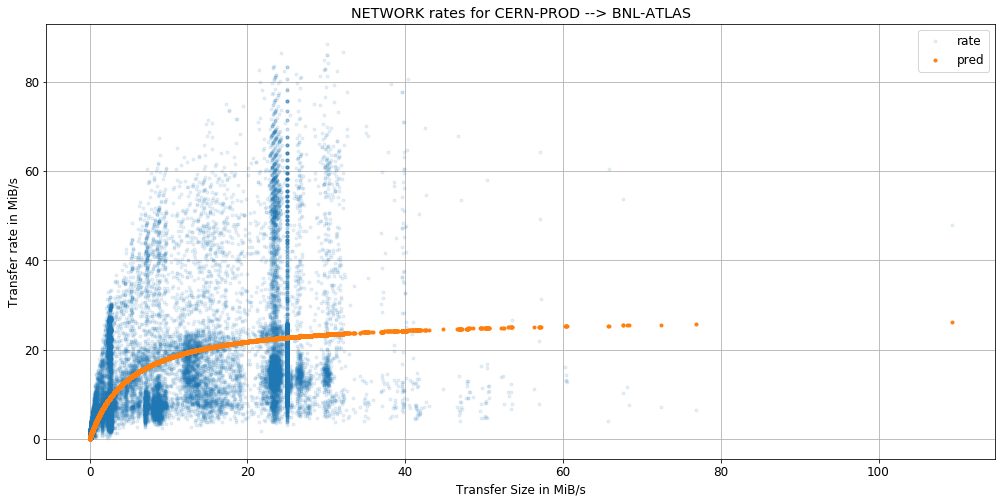

In [192]:
plt.plot(cut.SIZE_MB/100, cut.N_RATE_MB,'.', label='rate',alpha=0.1)
plt.plot(cut.SIZE_MB/100, cut.NLFIT/(1024*1024),'.', label='pred')
plt.title('NETWORK rates for CERN-PROD --> BNL-ATLAS')
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel('Transfer Size in MiB/s')
plt.ylabel('Transfer rate in MiB/s')

fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
print ('MAE:%.02f R²:%.02f'%(mae(cut.N_RATE_MB, cut.NLFIT/(1024*1024)),r2(cut.N_RATE, cut.NLFIT)))
plt.show()

In [132]:
def gethist2d(x, y, xbins=10, ybins=10):
    xmin = x.min()
    xmax = x.max()
    ymin = y.min()
    ymax = y.max()
    result = np.zeros((ybins+1, xbins+1))
    for i,j in zip(x,y):
        x_i = int(((i-xmin)/(xmax-xmin))*xbins)
        y_i = int(((j-ymin)/(ymax-ymin))*ybins)
        result[y_i][x_i] += 1
    return result        

/home/ivukotic/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


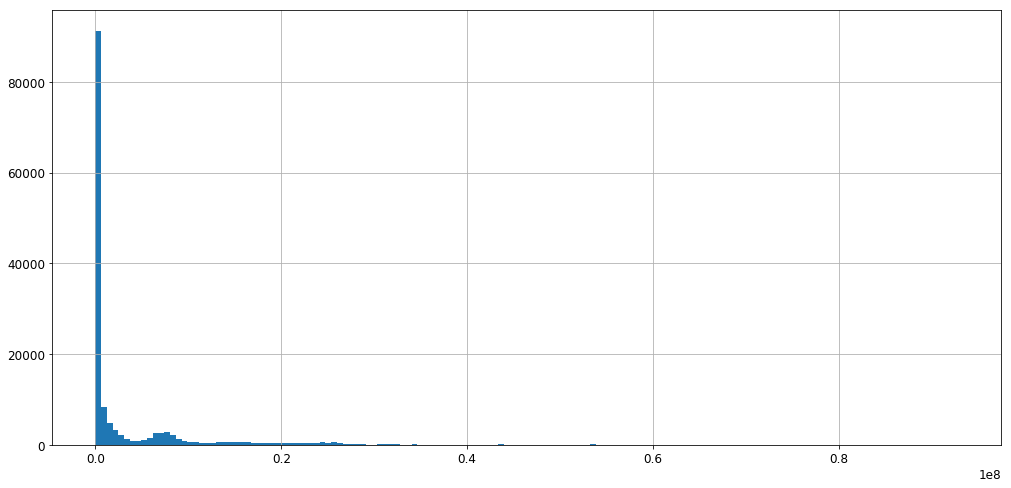

In [196]:
plt.hist(cut.N_RATE, bins=150)

fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()

/home/ivukotic/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


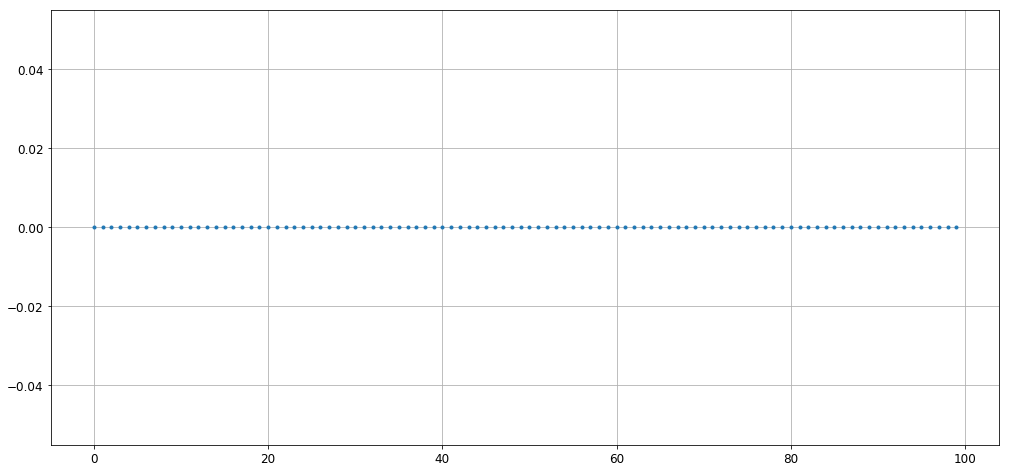

In [190]:
hmean = []
for i in range(100):
    hmean.append(r[i].min())
plt.plot(hmean,'.')
#plt.xscale('log')
#plt.yscale('log')
#plt.xlabel('Transfer Size in MiB/s')
#plt.ylabel('Transfer rate in MiB/s')

fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()